In [1]:
import math
import numpy as np
import random

class PointQueueEnv():
    def __init__(self, name, demand = "constant"):
        self.lambda1 = 1
        self.lambda2 = 2
        self.q1, self.C1 = 30.0, 30.0
        self.q2, self.C2 = 60.0, 30.0
        self.g1 = 30.0
        self.g2 = 30.0
        self.q3 = 0
        self.u = math.log(2)
        self.CumLambda1 = 0
        self.CumG1 = 0
        self.step = 0
        self.model_name = name
        # self.state = [self.lambda1/200.0, self.lambda2/500.0, self.q1/10.0, self.q2/60.0, self.q3/60.0]
        self.state = np.array([self.lambda1 / 200.0, self.lambda2 / 500.0, self.q1 / 10.0, self.q2 / 60.0, self.q3 / 60.0], dtype=np.float32)
        self.demand = demand
        self.w_dif = self.lambda2 / self.C2 - self.lambda1 / self.C1
        
        self.CT=0
        self.TSTT=0



        self.lambda1L = []
        self.lambda2L = []
        self.q1L, self.C1L = [], []
        self.q2L, self.C2L = [], []
        self.q3L = []
        self.uL = []
        self.g1L, self.g2L = [], []
        self.w_difL = []

    def calCapacity(self):
        if self.lambda1 == 0:
            self.C1 = 30
        else:
            self.C1 = 30 * (1 - 0.1)
        if self.lambda2 == 0:
            self.C2 = 30
        else:
            self.C2 = 30 * (1 - 0.1)

    def calQnum(self):
        self.lambda1 = max((self.q1 + self.q3 - self.C1) / 600.0 + self.lambda1, 0)
        self.lambda2 = max((self.q2 - self.q3 - self.C2) / 600.0 + self.lambda2, 0)
        self.CumLambda1 += self.lambda1
        self.lambda1L.append(self.lambda1)
        self.lambda2L.append(self.lambda2)

    def calOutflow(self):
        self.g1 = min(self.q1 + self.q3+1000000000*self.lambda1, self.C1)/600
        self.g2 = min(self.q2 - self.q3+1000000000*self.lambda1, self.C2)/600
        self.g1L.append(self.g1)
        self.g2L.append(self.g2)
        self.CumG1 += self.g1

    def calTimeDif(self):
        self.w_dif = self.lambda2 / self.C2 - self.lambda1 / self.C1
        self.w_difL.append(self.w_dif)

    def calQ3(self):
        if self.model_name == "logit_rand":
            alpha = 10
            pi = 0.5
            rand = random.uniform(-0.1, 0.1)
            self.q3 = self.q2 / (1 + math.exp(alpha * (self.u - (1+rand) * pi * self.w_dif)))
            self.q3L.append(self.q3)
        if self.model_name == "logit":
            alpha = 1
            pi = 0.5
            self.q3 = self.q2 / (1 + math.exp(alpha * (self.u -  pi * self.w_dif)))
            self.q3L.append(self.q3)
        if self.model_name == "UE":
            pi = 0.5
            if self.w_dif == 0.0:
                if self.u == 0:
                    self.q3 = self.q2 * (self.C1 - self.q1) / (self.C1 - self.q1 + self.C2)
                else:
                    self.q3 = 0
            if self.w_dif != 0.0:
                if self.w_dif<0:
                    self.q3 = 0
                else:
                    try:
                        self.q3 = self.q2 / math.exp(self.u / (pi * self.w_dif))
                    except OverflowError:
                        self.q3 = 0
                        # print("OverflowError")
            self.q3L.append(self.q3)

    def setPrice(self, price):
        self.u = price


    def getDemand(self, i):
        # self.q1 = max(2, min(i / 30.0, 10, (40 - i / 30.0)))
        # self.q2 = max(31, min(i / 5.0, 60, (240 - i / 5.0)))
        if self.demand == 'constant':
            self.q1 = 10
            self.q2 = 60
        elif self.demand == 'random':
            self.q1 = np.random.poisson(lam=10)
            self.q2 = np.random.poisson(lam=60)
        elif self.demand =='var1':
            pass
        self.q1L.append(self.q1)
        self.q2L.append(self.q2)


    def update(self):
        ###whether capacity drop
        # self.calCapacity()
        self.getDemand(self.step)
        self.calTimeDif()
        self.calQ3()
        self.calQnum()
        self.calOutflow()
        self.uL.append(self.u)
        
        self.CT=(self.lambda1*self.q1+self.lambda2*(self.q2-self.q3))*0.1/60
        self.TSTT+=self.CT
        self.step += 1
    
    def getdone(self):
        if self.step>=18000:
            return True
        # if self.lambda1>5:
        #     return True
        return False

    def reset(self):
        self.lambda1 = 1
        self.lambda2 = 2
        self.q1, self.C1 = 30.0, 30.0
        self.q2, self.C2 = 60.0, 30.0
        self.g1 = 30
        self.g2 = 30
        self.q3 = 0
        self.u = math.log(2)
        self.CumLambda1 = 0
        self.CumG1 = 0
        self.step = 0
        self.R=0
        self.ToR=0
        self.CT=0
        self.TSTT=0
        

        self.lambda1L = []
        self.lambda2L = []
        self.q1L, self.C1L = [], []
        self.q2L, self.C2L = [], []
        self.q3L = []
        self.uL = []
        self.g1L, self.g2L = [], []
        self.w_difL = []

    def getList(self):
        return self.lambda1L, self.lambda2L, self.q1L, self.C1L, self.q2L, self.C2L, self.q3L, self.uL, self.g1L, self.g2L, self.w_difL

    # def getState(self):
    #     stdLambda1 = self.lambda1/200.0
    #     stdLambda2 = self.lambda2/500.0
    #     stdQ1 = self.q1/10.0
    #     stdQ3 = self.q3/30.0
    #     stdG1 = self.g1/30.0
    #     stdG2 = self.g2/30.0
    #     s = np.array([stdLambda1, stdLambda2], dtype=np.float32)
    #     # s = np.array([stdLambda1, stdLambda2, stdQ1, stdQ3, stdG1, stdG2], dtype=np.float32)
    #     return s
    ###time-dependant demands
    def getState(self):
        stdLambda1 = self.lambda1/100
        stdLambda2 = self.lambda2/300
        stdQ1 = self.q1/20
        stdQ2 = self.q2/70
        stdQ3= self.q3/70
        stdG1=self.g1/30.0
        stdG2 = self.g2 /30.0

        s = np.array([stdLambda1, stdLambda2, stdQ1, stdQ2, stdQ3], dtype=np.float32)
        # s = np.array([stdLambda1, stdLambda2, stdQ1, stdQ3, stdG1, stdG2], dtype=np.float32)
        return s

    def getReward(self):
        self.reward = max(-1, (self.g1-0.012*self.lambda1))/1200             ###最大化吞吐量
#         self.reward= max(-1,self.R-0.015*self.lambda1)/1200                  ###收益最大化
#         self.reward=(10-self.CT-1.3*self.lambda1)/1200                        #最小化TSTT
        # self.reward = max(-1, (self.g1 - 5*self.lambda1)/30.0)
        # self.reward = self.g1/30 - 100 * self.lambda1/200
        # self.reward = self.g1 - 5*self.lambda1  #3,4,5 did not work
        # if self.g1==30 and self.lambda1 == 0:
        #     self.reward += 30
        # self.reward = (self.CumG1) - (self.CumLambda1)
        # self.reward = self.g1 - 10 * math.log(self.lambda1 + 1)
        return self.reward

In [2]:
import math
def VOT(vot,lanm1,delta1,k1=0.1,k2=0.1):
    vot=vot+(k1*lanm1-k2*delta1)*0.1/60
    return vot

def solu(vot,w,q1,q2):
    u=vot*w+math.log((q1+q2-30)/(30-q1))
    return u

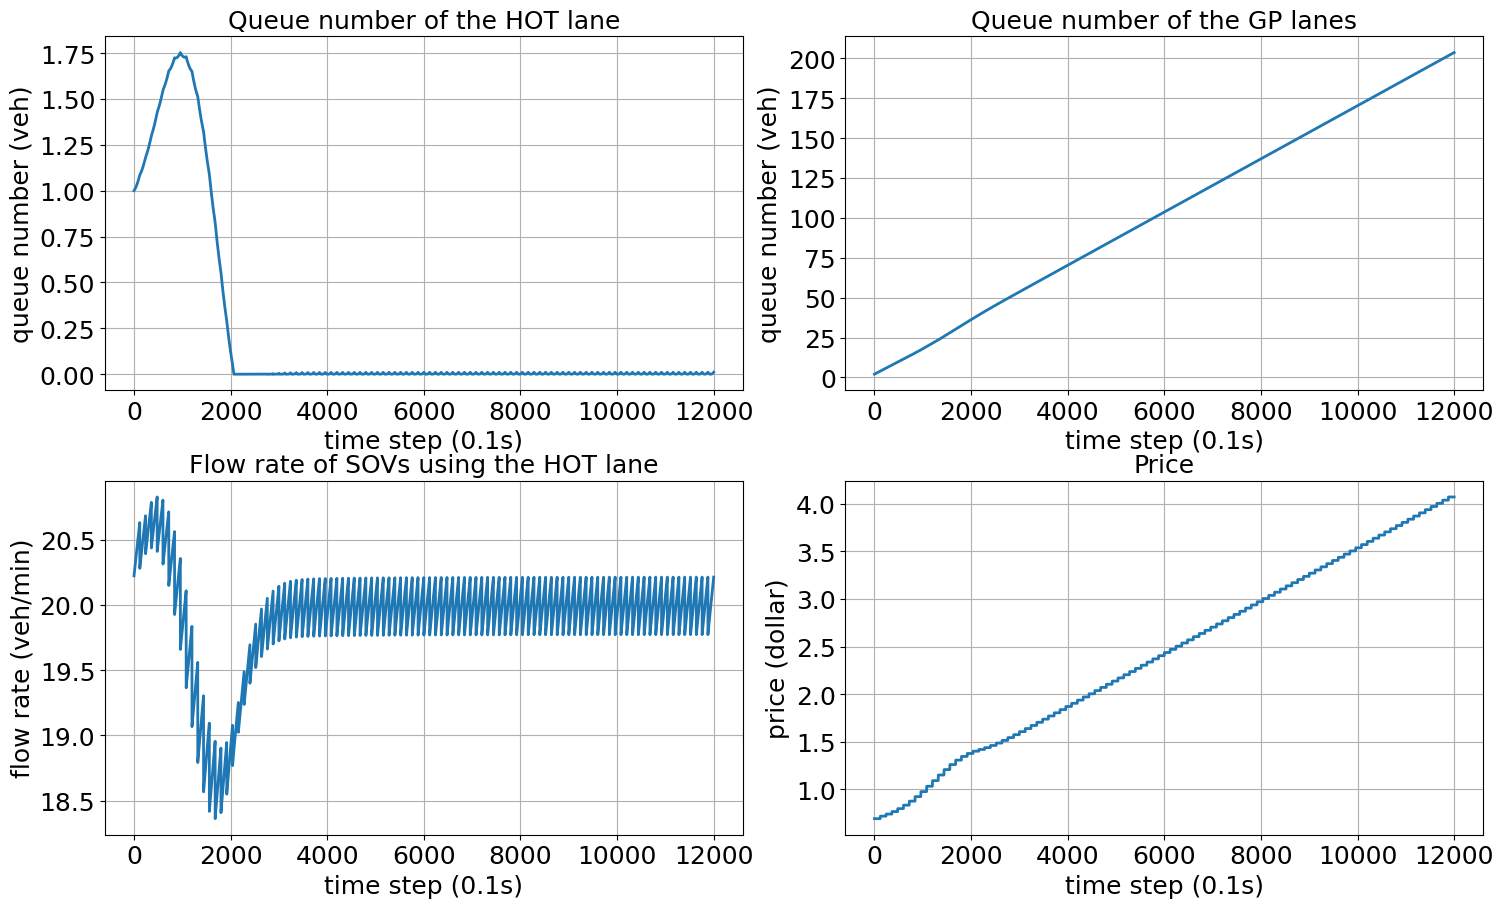

In [3]:
vot=0.25
VOTL=[0.25]
env = PointQueueEnv('logit')
for i in range(100):
    for j in range(120):
        env.update()
        q1, q2,q3, w1,lambda1= env.q1,env.q2,env.q3,env.w_dif,env.lambda1
        delta1=30-q1-q3
        vot=VOT(vot,lambda1,delta1)
        VOTL.append(vot)
    u = solu(vot,w1,q1, q2)
    env.setPrice(u)
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
plt.plot(env.lambda1L, '-', lw=2)            
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=18)
plt.ylabel(...,fontsize=18)
plt.xlabel('time step (0.1s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of the HOT lane',fontsize=18)

plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(env.lambda2L, '-', lw=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=18)
plt.ylabel(...,fontsize=18)
plt.xlabel('time step (0.1s)')
plt.ylabel('queue number (veh)')
plt.title('Queue number of the GP lanes',fontsize=18)
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(env.q3L, '-', lw=2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=18)
plt.ylabel(...,fontsize=18)
plt.xlabel('time step (0.1s)')
plt.ylabel('flow rate (veh/min)')
plt.title('Flow rate of SOVs using the HOT lane',fontsize=18)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# 设置坐标标签字体大小
plt.xlabel(...,fontsize=18)
plt.ylabel(...,fontsize=18)
plt.plot(env.uL, '-', lw=2)
plt.xlabel('time step (0.1s)',fontsize=18)
plt.ylabel('price (dollar)')
plt.title('Price',fontsize=18)
plt.grid(True)
plt.tight_layout(pad=0.4, w_pad=0, h_pad=0)
plt.savefig('123.png')


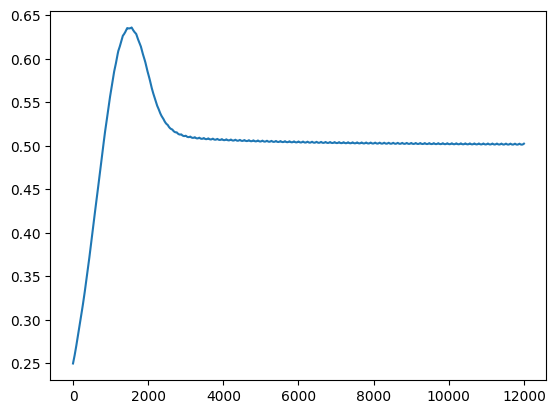

In [4]:
plt.plot(VOTL)

In [9]:
env.CumG1,env.CumLambda1,max(env.lambda1L)

(599.2503308414364, 2555.1005627721297, 1.7532209526899352)